# File Description

The purpose of this file is to test some visualisations of the data of bathymetry of Tarawa. The data comes from www.pacgeo.org
There are two groups of data: Ocean side and Lagoon side.
    
The details on the webpage and the metadata are pretty vague. Not sure at this stage what the coordinate system is.

The data was download as zipped shapefiles from:
    -http://www.pacgeo.org/layers/geonode:ki_tarawa_ocean_side_mbes_bathy_20m_grid
    -http://www.pacgeo.org/layers/geonode:ki_tarawa_mbes_bathy_lagoon_20m_grid
            
Both are on a 20m grid

In [1]:
# # Map of Bathymetry:
# import wand
# from wand.image import Image as WImage
# img = WImage(filename='140_ki_tarawa_bathy_1_to_100_000_p59Jd3Q.pdf')
# img

# File Setup

In [2]:
import shapefile
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import geopandas as gpd
import sklearn
import scipy.interpolate
import rpy2
import os
os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'

from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math
import pyproj
import itertools 
import alphashape
import descartes
import sys
import shapely

%load_ext rpy2.ipython
# from notebook.services.config import ConfigManager
# cm = ConfigManager().update('notebook', {'limit_output': 10})

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_GMT.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_GMT.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_GMT.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_GMT.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.

C:\P

# Bathymetry Data Import

In [3]:
# Load the data using geopandas

folder_loc = r'C:\Users\shannonb\Documents\Model_and_data\Dataset\D1_bathymetry'

gdf_lagoon = gpd.read_file('{}\ki_tarawa_mbes_bathy_lagoon_20m_grid.shp'.format(folder_loc))
gdf_ocean = gpd.read_file('{}\ki_tarawa_ocean_side_mbes_bathy_20m_grid.shp'.format(folder_loc))

# convert the geopandas to pandas
df_lagoon = pd.DataFrame(gdf_lagoon)
df_ocean = pd.DataFrame(gdf_ocean)

# # Sample the data to make it faster....
# df_ocean = df_ocean.sample(1000)
# df_lagoon = df_lagoon.sample(1000)

# Convert the data to float
df_ocean = df_ocean[['X','Y','A']].astype({'X':float,'Y':float,'A':float})
df_lagoon = df_lagoon[['X','Y','A']].astype({'X':float,'Y':float,'A':float})

# Combine the dataframes
df_bath = df_ocean.append(df_lagoon)

# Preprocessing of Bathymetry Data

In [4]:
df_bath = df_ocean

In [5]:
df_test = df_bath.copy()

grid_size = 0.001

# Chop off part that's not the tarawa atoll
df_test = df_test[df_test.Y<185000]

# Make depth positive
df_test['A'] = -df_test['A']

######################################################################
###################################################################### 
######################################################################
# use a transformer to convert from WGS UTM zone 59 N metres to geodetic degrees

transformer = \
    pyproj.Transformer.from_crs(pyproj.CRS("EPSG:32659"),pyproj.CRS("epsg:4326"))

df_test['XY'] = [transformer.transform(x,y) for x,y in zip(df_test.X,df_test.Y)]

df_test['Y'] = [row[0] for row in df_test['XY']]
df_test['X'] = [row[1] for row in df_test['XY']]
df_test.drop('XY',axis=1,inplace=True)

######################################################################
###################################################################### 
######################################################################

# Group into grid
df_test['X'] = (round(df_test.X/grid_size))*grid_size
df_test['Y'] = (round(df_test.Y/grid_size))*grid_size

# # Convert to km
# df_test['X'] = df_test['X']/1000.0
# df_test['Y'] = df_test['Y']/1000.0

# Make log scale
exp = 0.5
df_test['A'] = [x**exp for x in df_test['A']]

df_pivot = df_test.pivot_table(index='Y',columns='X')['A']
# test_array = np.array(df_test)

# Get GIS data

In [6]:
# Load the data using geopandas

folder_loc = r'C:\Users\shannonb\Documents\Model_and_data\Dataset\Additional_data\Land_use_cover'

gdf_veg = gpd.read_file('{}\kiribati_vector.shp'.format(folder_loc))

# convert the geopandas to pandas
df_veg = pd.DataFrame(gdf_veg)


(1.3, 1.68)

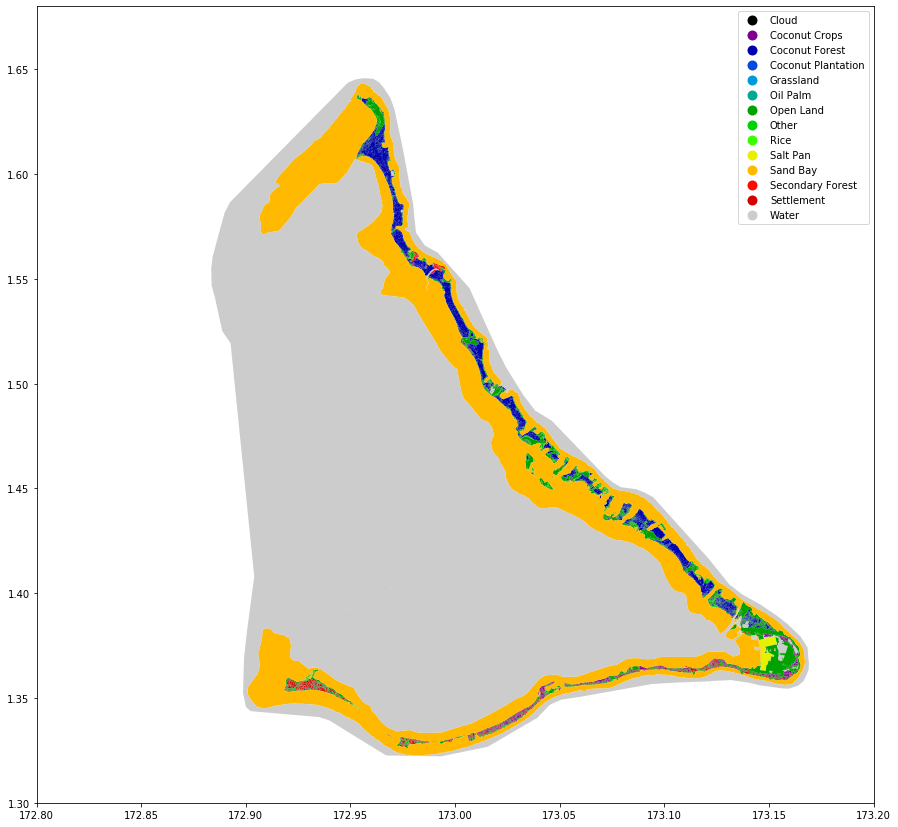

In [7]:
fig = plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((1,1),(0,0))

gdf_veg.plot(column='CLASS_NAME',legend=True,ax=ax1,cmap='nipy_spectral')

gdf_land = gdf_veg[(gdf_veg['CLASS_NAME']!='Water')&(gdf_veg['CLASS_NAME']!='Sand Bay')]

ax1.set_xlim(172.8,173.2)
ax1.set_ylim(1.3,1.68)

# Plotting Bathymetry and GIS data

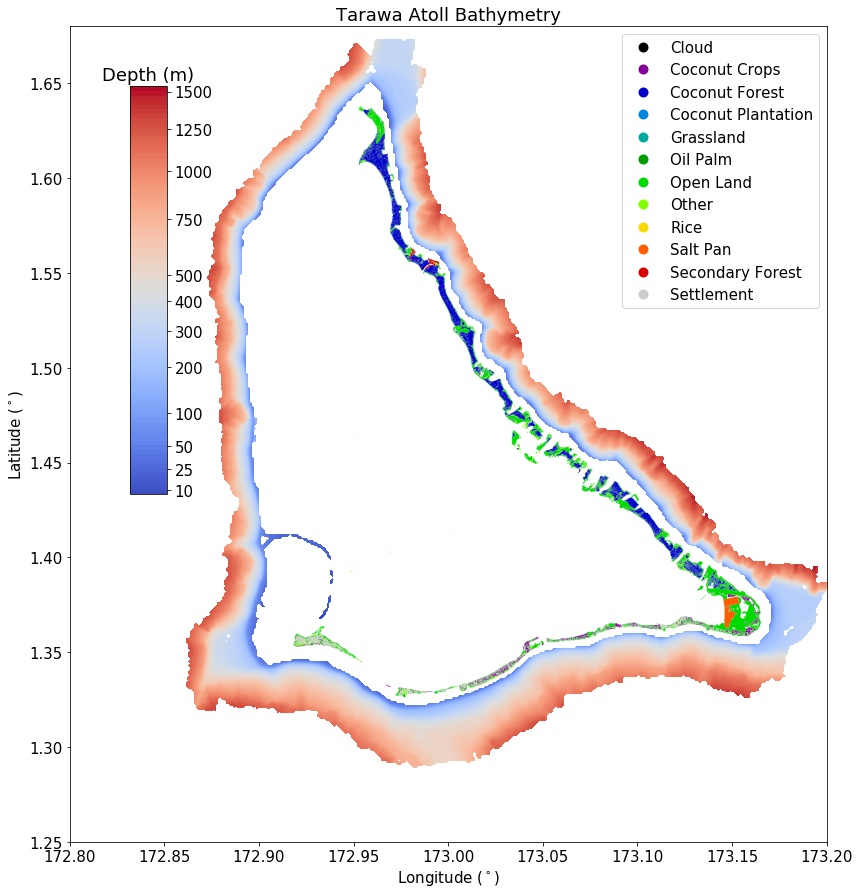

In [18]:
cmap='coolwarm'

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(15,15))

ax = plt.subplot2grid((1,1),(0,0))

X,Y = np.meshgrid(list(df_pivot.columns),list(df_pivot.index))

output = ax.contourf(X,Y,df_pivot,cmap=cmap,levels=100)

ax.set_ylabel('Latitude ($^\circ$)')
ax.set_xlabel('Longitude ($^\circ$)')
ax.set_title('Tarawa Atoll Bathymetry')

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

# ax.set_xlim(np.min(ax.get_xlim())-2.5,np.max(ax.get_xlim())+2.5)
# ax.set_ylim(np.min(ax.get_ylim())-2.5,np.max(ax.get_ylim())+2.5)

ax.tick_params(axis='x', which='minor', bottom=False)

# ax.grid(True,which='both',axis='both')

cax = inset_axes(ax,
                    width="5%",  # width = 50% of parent_bbox width
                    height="50%",  # height : 5%
                    loc='upper left',
                    borderpad=4)

cbar = fig.colorbar(output,cax=cax)
cax.set_title('Depth (m)')
y_ticks =  cax.get_yticks()
# cbar.set_ticklabels([round(y**(1/exp)) for y in y_ticks])

levels = [1500,1250,1000,750,500,400,300,200,100,50,25,10,5]
levels_exp = [x**(exp) for x in levels]
cbar.set_ticks(levels_exp)
cbar.set_ticklabels(levels)

####

gdf_land.plot(column='CLASS_NAME',legend=True,ax=ax,cmap='nipy_spectral')

ax.set_xlim(172.8,173.2)
ax.set_ylim(1.25,1.68)

plt.show()


In [9]:
gpd.points_from_xy(x=[1.4],y=[173])

<GeometryArray>
Length: 1, dtype: geometry

In [10]:
longs = np.arange(172.85,173.20,0.001)
lats = np.arange(1.3,1.65,0.001)

df_grid = pd.DataFrame(itertools.product(longs,lats))
df_grid['point'] = 'point'

gdf_grid = gpd.GeoDataFrame(df_grid, geometry=gpd.points_from_xy(df_grid[0], df_grid[1]), crs="epsg:4326")

df_gridded_land = gpd.sjoin(gdf_grid,gdf_land,op='within')

In [11]:
alpha_shapes = alphashape.alphashape([(x,y) for x,y in zip(df_gridded_land[0],df_gridded_land[1])],500.0)

In [12]:
alpha_shapes_bath = alphashape.alphashape([(x,y) for x,y in zip(df_test['X'],df_test['Y'])],50000.0)

#### NOTE FOR TOMORROW
#### DF BATH SHOULDN'T BE USED FOR HTE ALPHA SHAPE. YOU WANT THE INTERNAL NO DATA TO BE THE SHAPE

In [13]:
plt.scatter(df_no_bathymetry.X,df_no_bathymetry.value)

NameError: name 'df_no_bathymetry' is not defined

In [ ]:
fig = plt.figure(figsize = (10,10))


ax = plt.subplot2grid((1,1),(0,0))

ax.scatter(df_gridded_land[0],df_gridded_land[1])

ax.add_patch(descartes.PolygonPatch(alpha_shapes,alpha=0.2))
ax.add_patch(descartes.PolygonPatch(alpha_shapes_bath,alpha=0.2))

In [ ]:
list(alpha_shapes)

In [ ]:

shorelines_dict = {}
i = 0

# loop over each of the islands
for alpha_shape in list(alpha_shapes):
    xy = alpha_shape.exterior.coords.xy
    n=2 # length of the shift

    df_shoreline = pd.DataFrame({'x':xy[0][::n],
                                 'x+n':list(xy[0][(n)::n])+[np.nan],
                                 'y':xy[1][::n],
                                 'y+n':list(xy[1][(n)::n])+[np.nan]})

    # df_shoreline['x+n'] = list(df_shoreline.loc[n:,'x'])+[np.nan]*n
    # df_shoreline['y+n'] = list(df_shoreline.loc[n:,'y'])+[np.nan]*n

    # Calculate the gradient of the line between the two shoreline points
    df_shoreline['m'] = (df_shoreline['y']-df_shoreline['y+n'])/(df_shoreline['x']-df_shoreline['x+n'])
    df_shoreline.dropna(axis=0,inplace=True)

    # Find the inverse of the gradient (because we are wanting the line that is perpendicular to the shoreline)
    df_shoreline['m'] = -df_shoreline['m']**-1

    # Manually set gradient=0 for vertical sections of shoreline
    df_shoreline.loc[((df_shoreline['x']-df_shoreline['x+n'])==0),'m']=0    
    
    df_shoreline['x_avg'] = [x/2 for x in (df_shoreline['x']+df_shoreline['x+n'])]
    df_shoreline['y_avg'] = [y/2 for y in (df_shoreline['y']+df_shoreline['y+n'])]

    df_shoreline['c'] = df_shoreline['y_avg']-df_shoreline['m']*df_shoreline['x_avg']

    # df_shoreline['x_proj'] = df_shoreline['x_avg']+0.01
    # df_shoreline['y_proj'] = df_shoreline['m']*df_shoreline['x_proj']+df_shoreline['c']

    H = 0.01 # length of the line
    delta_y = [abs(H*math.sin(math.atan(m))) for m in df_shoreline['m']]
    delta_x = [abs(H*math.cos(math.atan(m))) for m in df_shoreline['m']]

    # df_shoreline['y_new'] = df_shoreline['y_avg']+delta_y
    # df_shoreline['x_new'] = df_shoreline['x_avg']+delta_x

    df_shoreline['x_new'] = [(x_avg+dx) if y1>y2 else (x_avg-dx) for y1,y2,x_avg,dx in zip(df_shoreline['y'],df_shoreline['y+n'],df_shoreline['x_avg'],delta_x)]
    df_shoreline['y_new'] = [(y_avg+dy) if x1<x2 else (y_avg-dy) for x1,x2,y_avg,dy in zip(df_shoreline['x'],df_shoreline['x+n'],df_shoreline['y_avg'],delta_y)]

    
    ## Determine if the shapes intersect land
    df_shoreline['lines'] = [shapely.geometry.LineString([[np.mean([x_avg,x_new]),np.mean([y_avg,y_new])],[x_new,y_new]]) for x_avg,x_new,y_avg,y_new in zip(
        df_shoreline.x_avg,df_shoreline.x_new,df_shoreline.y_avg,df_shoreline.y_new
    )]
    
#     for line in df_shoreline.lines:
    df_shoreline['ocean_facing'] = [all(~np.array([line.intersects(island) for island in list(alpha_shapes)])) for line in df_shoreline.lines]
    df_shoreline = df_shoreline[df_shoreline.ocean_facing==True]
    
    # Add shorelines to dictionary 
    shorelines_dict.update({
        i:{
            'df':df_shoreline,
            'poly':alpha_shape
        }
    })
    i+=1
    

In [ ]:
df_shoreline

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot2grid((1,1),(0,0))

for key,item in shorelines_dict.items():
    
    df_shoreline = item['df']
    alpha_shape = item['poly']
    
    [ax.plot([x,x_n],[y,y_n],alpha=0.5,c='k') for x,x_n,y,y_n in zip(
        df_shoreline['x'],
        df_shoreline['x+n'],
        df_shoreline['y'],
        df_shoreline['y+n']
    )]

    [ax.plot([x_avg,x_proj],[y_avg,y_proj],alpha=0.5,c='r') for x_avg,x_proj,y_avg,y_proj in zip(
        df_shoreline['x_avg'],
        df_shoreline['x_new'],
        df_shoreline['y_avg'],
        df_shoreline['y_new']
    )]

    ax.add_patch(descartes.PolygonPatch(alpha_shape,alpha=0.2))
    
ax.set_xlim(172.8,173.2)
ax.set_ylim(1.25,1.68)

# test = df_shoreline.loc[215]

# x_test = np.arange(test.x_avg,test.x_new,(test.x_new-test.x_avg)/100)
# y_test = np.arange(test.y_avg,test.y_new,(test.y_new-test.y_avg)/100)

# x_test
# plt.plot(x_test,y_test,c='b')

plt.show()

# Find the closest Depth to the Shore

In [ ]:
df_test2 = df_test.copy()

df_test2['dist_shore'] = ((df_test2.X-test.x_avg)**2+(df_test2.Y-test.y_avg)**2)**0.5

df_test2[df_test2.dist_shore==np.min(df_test2.dist_shore)]

# Making Some transects

## Data for checking the transects

In [ ]:


# df_pivot_filtered = df_pivot.loc[:,(df_pivot.columns<717.5)&(df_pivot.columns>716.5)]
# df_pivot_filtered = df_pivot_filtered[(df_pivot_filtered.index<146.5)&(df_pivot_filtered.index>143.5)]
df_pivot_filtered = df_pivot


## Test Point

In [ ]:
import statsmodels.api as sm
from scipy import interpolate
from numpy import diff
# from kneed import KneeLocator
# x = np.arange(741,744,(744-741)/100.0)
# y = np.arange(153,154,(148-147)/100.0)#[147]*len(x)

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return(ret[n - 1:] / n)

def transect_determination(df_bathymetry,n):
    '''
    inputs:
        - n is period of moving average
    '''
    
    # Set location for x and y transect temporarily
#     x = [721]*50
#     y = np.arange(146,143,(143-146)/50)
    x = x_test#np.arange(712,708,(712-708)/100.0)
    y = y_test#np.arange(153,154,(154-152)/100.0) # [147]*len(x)
#     x = np.arange(718,717.0,-(718-717)/100.0)
#     y = np.arange(147,143.0,-(147-143)/100.0)

    # Get the coordinates and depths of the island
    points = np.array(df_bathymetry[['X','Y']])
    values = np.array(df_bathymetry['A'])

    # Calculate the depth along the transect coordinates x and y
    transect_depth = interpolate.griddata(points,values,(x,y),method='cubic')
    
    # Create a transect dataframe with coordinates and depths
    df_transect = pd.DataFrame({'long':x,'lat':y,'depth':transect_depth})
    df_transect.dropna(inplace=True)
    
    # Set latitude and longtidue to be the first value in the transect #### REPLACE WITH SHORE VALUE WHEN I HAVE IT
    zero_point_long = df_transect.loc[0].long
    zero_point_lat = df_transect.loc[0].lat
    
    # Calculate distance from zero point (future: shore)
    df_transect['distance'] = np.sqrt((df_transect.long-zero_point_long)**2+\
                                        (df_transect.lat-zero_point_lat)**2)
    
    # Make sure transect is in order of distance
    df_transect.sort_values('distance',inplace=True)
    
    # Put a moving average through the depth
    depth_moving_avg = list(moving_average(list(df_transect.depth),n))
    length_of_nan = [np.nan]*int((n-1)/2)

    # Add to df_transect
    df_transect['depth_moving_avg'] = length_of_nan+depth_moving_avg+length_of_nan
    df_transect.dropna(inplace=True,axis=0)
    
    return(df_transect)
    
def determine_crest_location(df_transect):
    '''
    '''
    
    # Find the second derivative
    depth_dash = diff(df_transect.depth_moving_avg)/diff(df_transect.distance)
    distance_average = [np.mean([x1,x2]) for x1,x2 in zip(df_transect.distance[1:],df_transect.distance[:-1])]
    
    df_dash = pd.DataFrame({
                'distance_average':distance_average,
                'depth_dash':depth_dash
            })
    
    df_dash.dropna(inplace=True,axis=0)
    
    # Find the double derivative
    depth_dashdash = np.diff(df_dash.depth_dash)/np.diff(df_dash.distance_average)
    distance_average_average = [np.mean([x1,x2]) for x1,x2 in zip(df_dash.distance_average[1:],df_dash.distance_average[:-1])]
    df_dashdash = pd.DataFrame({
                'distance_average_average':[abs(x) for x in distance_average_average],
                'depth_dashdash':depth_dashdash
            })
        
    # The elbow should be at the maximum in the double derivative
    df_crest_loc_deriv = df_dashdash[df_dashdash.depth_dashdash==np.max(df_dashdash.depth_dashdash)]
    
    # Get the distance from shore
    crest_dist_shore = df_crest_loc_deriv.reset_index().loc[0,'distance_average_average']
    
    # Get the location of the crest not in the derivative df    
    df_crest_loc = df_transect[\
               abs(df_transect.distance-crest_dist_shore)==np.min(abs(df_transect.distance-crest_dist_shore))]
    
    return(df_dashdash,df_crest_loc)

def beta_calculation(df_transect,df_crest_loc):
    '''
    
    '''
    
    # Divide the transect into reef flat and fore reef
    df_fore_reef = df_transect.loc[[x for x in df_transect.index if x>df_crest_loc.index[0]]]
    df_reef_flat = df_transect.loc[[x for x in df_transect.index if x<df_crest_loc.index[0]]]

    # Fit a linear regression of reef flat
    reef_flat_distance = sm.add_constant(list(df_reef_flat.distance)) # create a var for this algorithm for distance
    lin_reg_reef_flat = sm.OLS(list(df_reef_flat.depth),reef_flat_distance).fit()
    lin_reg_reef_flat_pred = lin_reg_reef_flat.predict(reef_flat_distance)
    
    # Fit linear regression to fore reef
    fore_reef_distance = sm.add_constant(list(df_fore_reef.distance)) # create a var for this algorithm for distance
    lin_reg_fore_reef = sm.OLS(list(df_fore_reef.depth),fore_reef_distance).fit()
    lin_reg_fore_reef_pred = lin_reg_fore_reef.predict(fore_reef_distance)
    
    # Create dataframes of linear regression results
    df_reef_flat_regression= pd.DataFrame({'distance':list(df_reef_flat.distance),'regression':lin_reg_reef_flat_pred})
    df_fore_reef_regression = pd.DataFrame({'distance':list(df_fore_reef.distance),'regression':lin_reg_fore_reef_pred})
    
    # Calculate beta using linear regression slopes 
    m_reef_flat = lin_reg_reef_flat.params[1]
    m_fore_reef = lin_reg_fore_reef.params[1]
    tan_beta = (m_fore_reef-m_reef_flat)/(1+m_fore_reef*m_reef_flat)
    #beta = math.atan(tan_beta)*180/math.pi
    
    beta = math.atan(m_fore_reef)*180/math.pi
    
    return(df_reef_flat_regression,df_fore_reef_regression,beta)

In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

df_transect = transect_determination(df_test,5)

ax1.plot(df_transect.distance,df_transect.depth_moving_avg)
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('Distance')
ax1.invert_yaxis()

df_dashdash,df_crest_loc = determine_crest_location(df_transect)

ax2.plot(df_dashdash.distance_average_average,df_dashdash.depth_dashdash)
ax1.scatter(df_crest_loc.distance,df_crest_loc.depth_moving_avg)
            
df_reef_flat_regression,df_fore_reef_regression,beta = beta_calculation(df_transect,df_crest_loc)

ax1.plot(df_reef_flat_regression.distance,df_reef_flat_regression.regression)
ax1.plot(df_fore_reef_regression.distance,df_fore_reef_regression.regression)

plt.show()

print(beta)

##############################################

In [ ]:
df_crest_loc

## Get Island Core

In [ ]:
df_island_and_lagoon = df_pivot.copy()

df_island_and_lagoon[~df_island_and_lagoon.isna()] = 0
df_island_and_lagoon[df_island_and_lagoon.isna()] = 1
df_island_and_lagoon[df_island_and_lagoon==0] = np.nan



In [ ]:
cmap='coolwarm'

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(15,15))

ax = plt.subplot2grid((1,1),(0,0))

X,Y = np.meshgrid(list(df_island_and_lagoon.columns),list(df_island_and_lagoon.index))

output = ax.contourf(X,Y,df_island_and_lagoon,cmap=cmap,levels=100)

ax.set_ylabel('Latitude (km)')
ax.set_xlabel('Longitude (km)')
ax.set_title('Tarawa Atoll Bathymetry')

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.set_xlim(np.min(ax.get_xlim())-2.5,np.max(ax.get_xlim())+2.5)
ax.set_ylim(np.min(ax.get_ylim())-2.5,np.max(ax.get_ylim())+2.5)

ax.tick_params(axis='x', which='minor', bottom=False)

ax.grid(True,which='both',axis='both')

cax = inset_axes(ax,
                    width="5%",  # width = 50% of parent_bbox width
                    height="50%",  # height : 5%
                    loc='upper right',
                    borderpad=4)

cbar = fig.colorbar(output,cax=cax)
cax.set_title('Depth (m)')
y_ticks =  cax.get_yticks()
# cbar.set_ticklabels([round(y**(1/exp)) for y in y_ticks])

levels = [1500,1250,1000,750,500,400,300,200,100,50,25,10,5]
levels_exp = [x**(exp) for x in levels]
cbar.set_ticks(levels_exp)
cbar.set_ticklabels(levels)

plt.show()


# Just trying some grouping...

In [ ]:
plt.scatter(df_test.X,df_test.Y,c=df_test.A)

In [ ]:
%%R -i df_test

plot(x=df_test$X,y=df_test$Y, pch=20)

##  Now get the polygons
ConvexHull = chull(df_test$X, df_test$Y)
polygon(df_test[ConvexHull,], 
    border=rainbow(4)[1], col=rainbow(4, alpha=0.1)[1])

In [ ]:
points = np.array(df_test[['X','Y']])

hull = scipy.spatial.ConvexHull(points)

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')


In [ ]:
np.array(df_test[['X','Y']])

In [ ]:
np.random.rand(30, 2)

In [ ]:
from math import sin, cos, sqrt, atan2, radians

lon1 = 72000
lat1 = 16000

for lon2,lat2 in zip(df_test.X,df_test.Y):

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    
    print("Result:", distance)